#  STL decomposition

This notebook will help you to understand the how to perform STL decomposition from scratch as well as using statsmodel library. Here I have take [Corporación Favorita retailer dataset from kaggle](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data) for the purpose.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
df_train = dd.read_csv('grocery_data/train.csv')

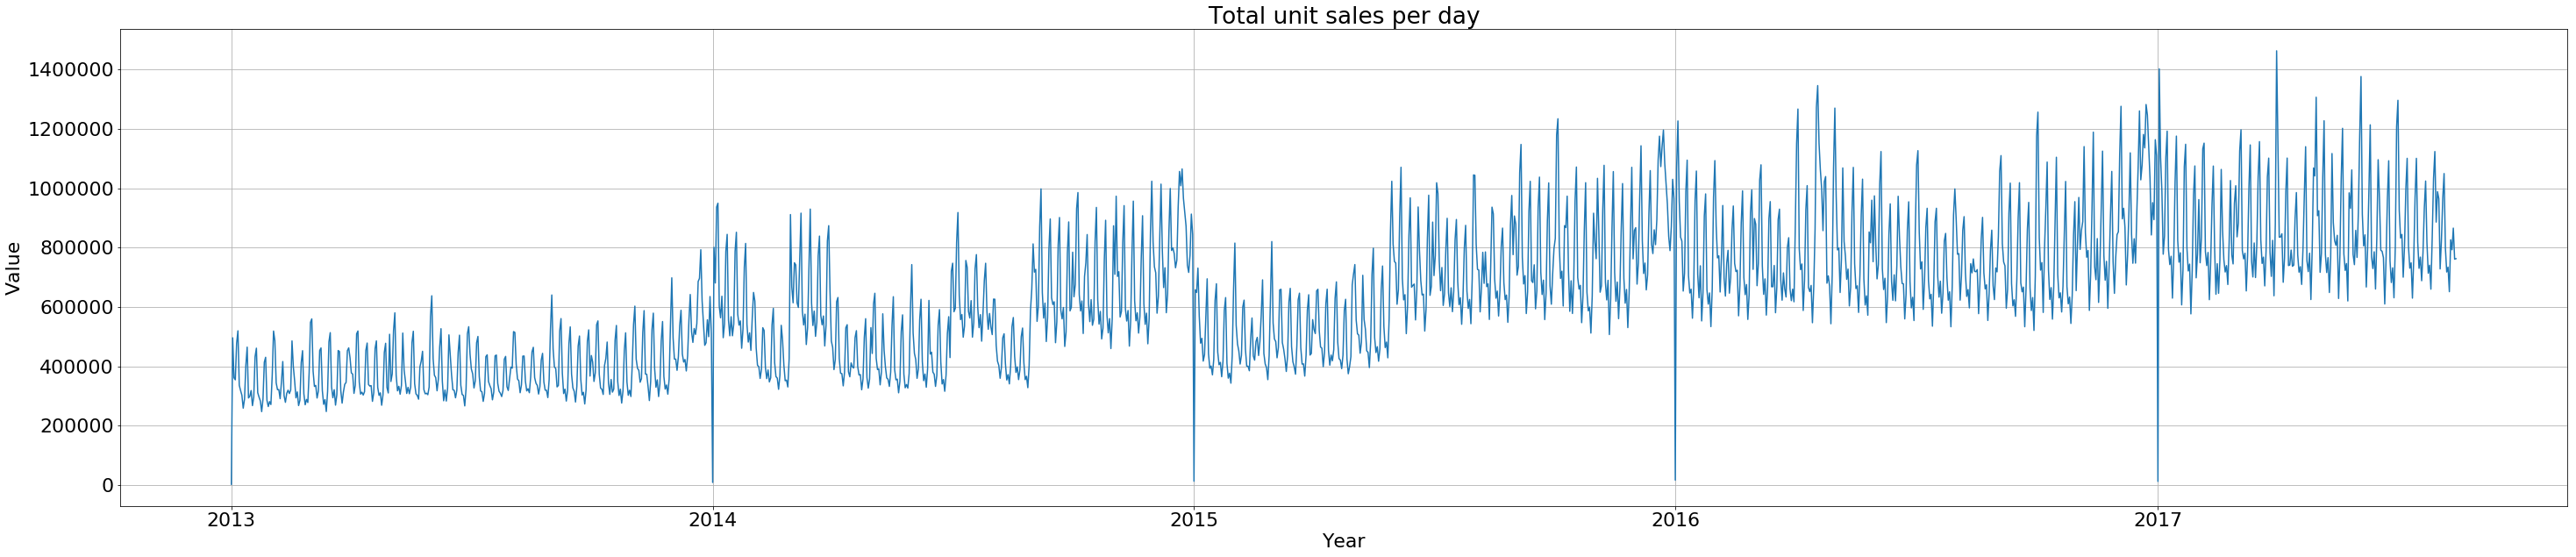

In [4]:
# creating a new dataframe for total unit sales from dash dataframe
chunksize = 10 ** 6
df = pd.DataFrame()
for chunk in pd.read_csv('grocery_data/train.csv', chunksize=chunksize):
    # grouping data to find the total unit sales per day
    data = chunk.groupby('date')['date', 'unit_sales'].sum()
    df = df.append(data)
df.reset_index(inplace=True)
df = df.groupby('date')['date', 'unit_sales'].sum()
df.reset_index(inplace=True)
# converting the date dtype from object to datetime
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(50,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(df['date'], df['unit_sales'], marker='', linestyle='-')
plt.title('Total unit sales per day')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

## STL decomposition from scratch

### Masking the data from 15th aug 2016 to 15th aug 2017 and aggregating at month level

In [14]:
data = df[(df.date.astype(str) >= '2013-01-01') & (df.date.astype(str) < '2017-01-01')].reset_index(drop=True)

# splitting the date column to day, month and year
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
# grouping the data to find the total unit sales per month
data = data.groupby(['month', 'year'])['date', 'unit_sales'].sum().sort_values(by=['year','month']).reset_index()
data.rename(columns={'unit_sales':'timeseries'}, inplace=True)
data.head()

,month,year,timeseries
0,1,2013,1.032741e+07
1,2,2013,9.658960e+06
2,3,2013,1.142850e+07
3,4,2013,1.099346e+07
4,5,2013,1.159770e+07


### Ploting the month level total unit sales

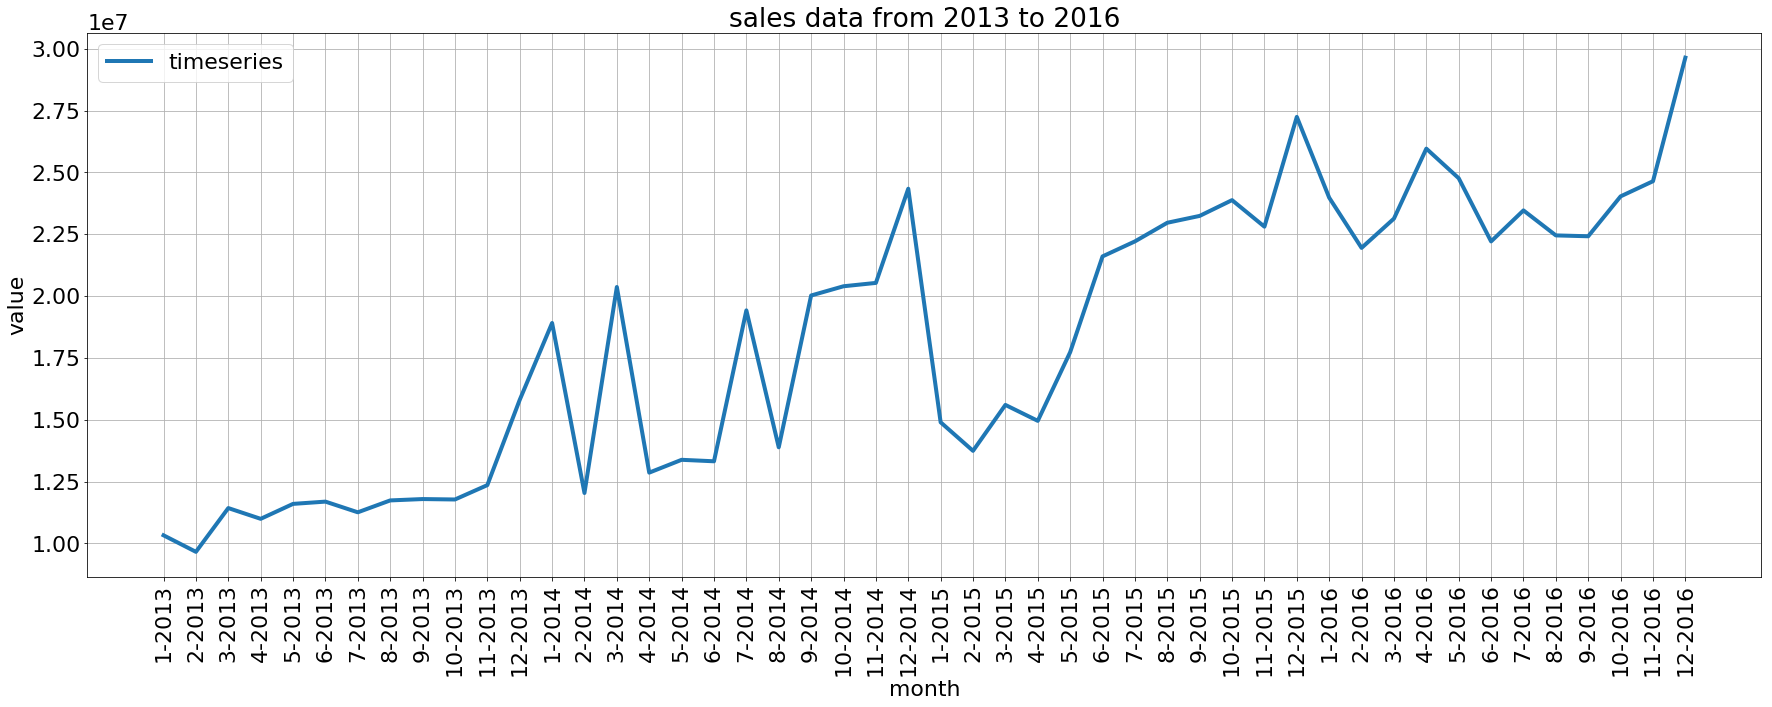

In [15]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
X_index = data['month'].astype('str')+ '-' + data['year'].astype('str')
plt.plot(X_index, data.timeseries, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Step 1: Find the approximate trend line

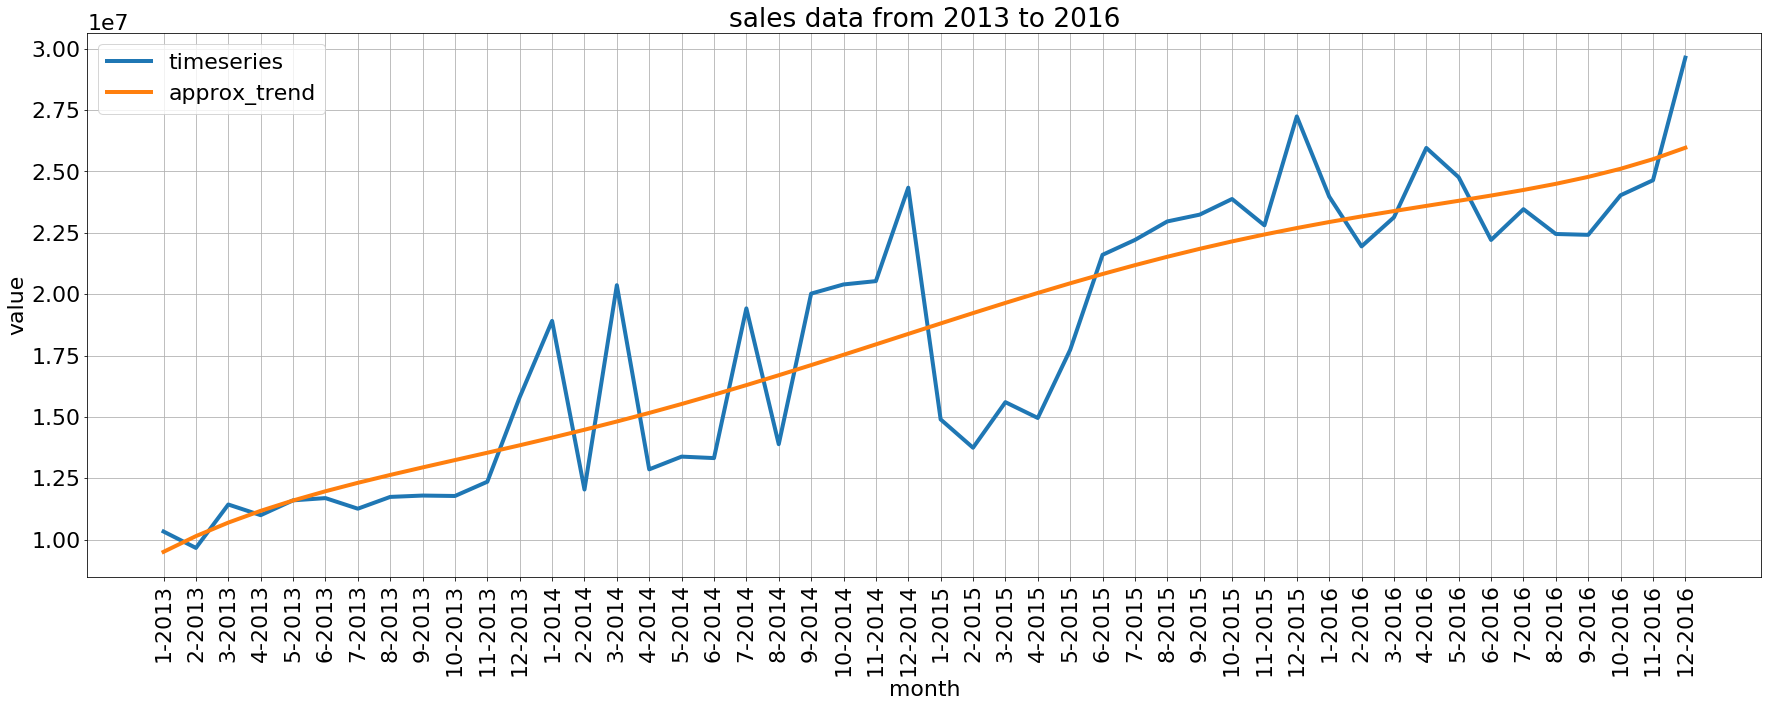

In [16]:
# importing libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# index
X = data.index.values
# timeseries value
y = data.timeseries.values

# scaling
scaler = MinMaxScaler()
scaler = scaler.fit(y.reshape(-1,1))
y_scaled = scaler.transform(y.reshape(-1,1))

# creating poly feature of degree 5
poly = PolynomialFeatures(5)
X_poly = poly.fit_transform(X.reshape(-1,1))

# fitting model
model = LinearRegression()
model = model.fit(X_poly, y_scaled)

# approx_trend 
approx_trend = model.predict(X_poly)
data['approx_trend'] = scaler.inverse_transform(approx_trend)

# plotting
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, y, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.plot(X_index, data.approx_trend, marker='', linestyle='-', label='approx_trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Step 2: Find the De-trended series

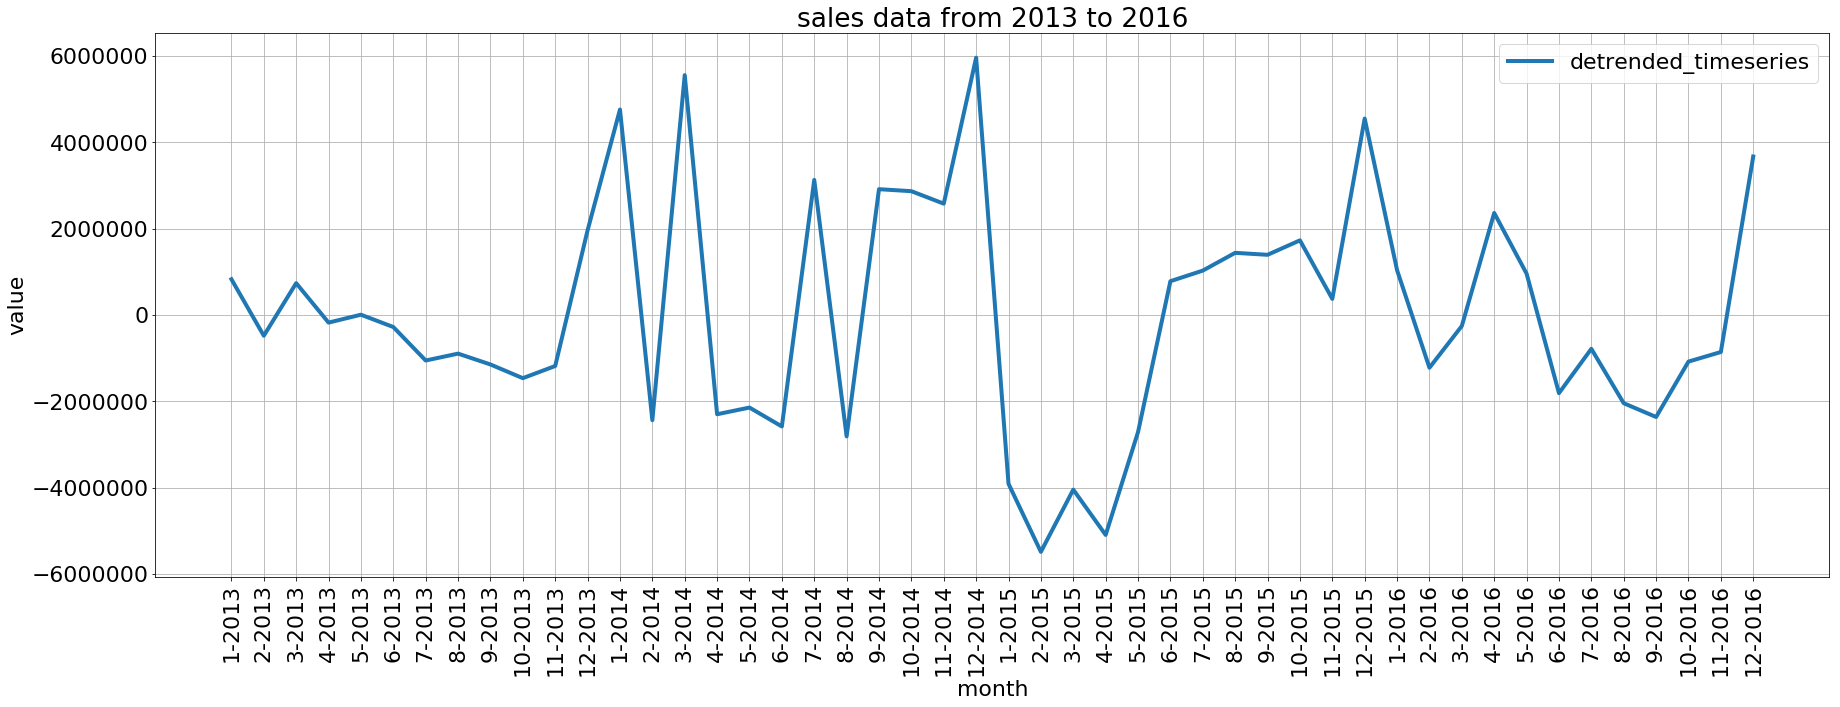

In [17]:
data['detrended_series'] = data.timeseries - data.approx_trend.values

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.detrended_series, marker='', linestyle='-', label='detrended_timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Step 3: Find the seasonal component

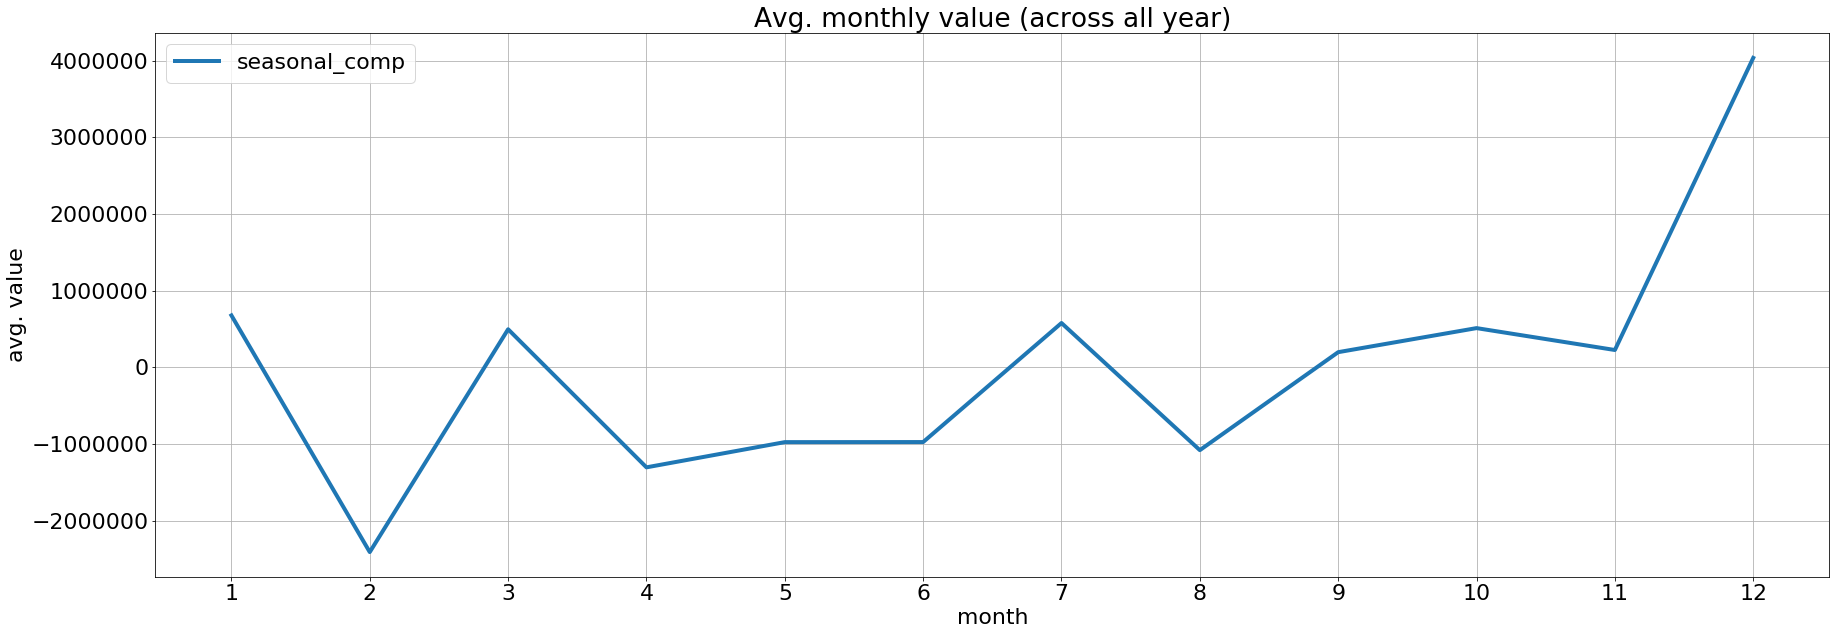

In [18]:
seasonal_comp = data.groupby('month')['month', 'detrended_series'].mean().reset_index(drop=True)

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(seasonal_comp.month.astype(str), seasonal_comp.detrended_series, marker='', linestyle='-', label='seasonal_comp', linewidth=4)
plt.title("Avg. monthly value (across all year)")
plt.xlabel("month")
plt.ylabel("avg. value")
plt.legend()
plt.show()

### Step 4: Replicate seasonal component across the whole data

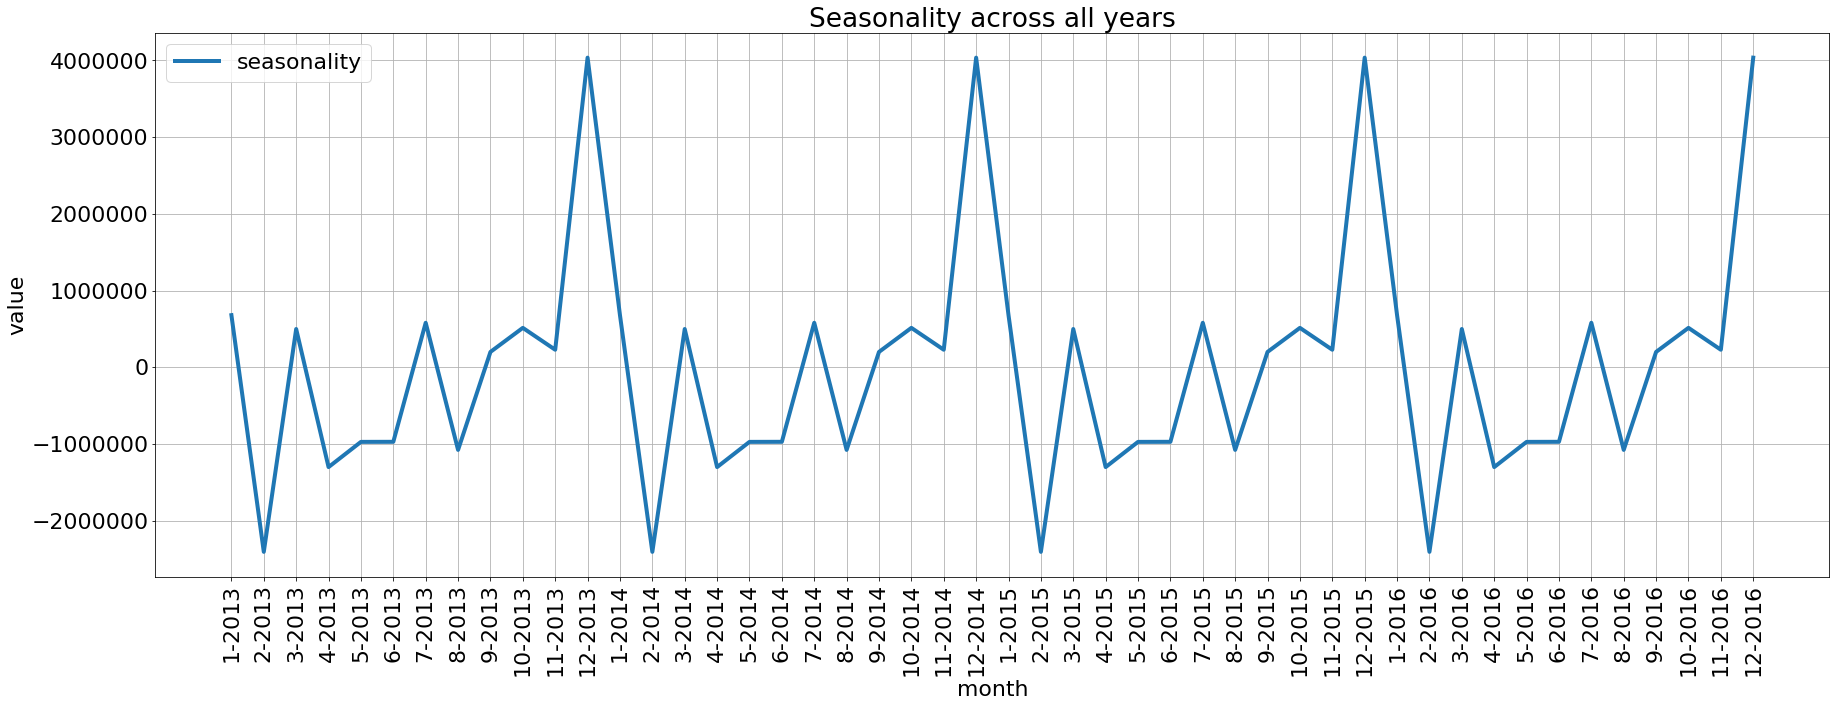

In [19]:
# replicate this seasonal component across the timeseries
seasonal = pd.DataFrame()
for i in range(int(data.timeseries.shape[0]/seasonal_comp.shape[0])):
    seasonal = pd.concat([seasonal, seasonal_comp])

data['seasonal'] = seasonal.detrended_series.values

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.seasonal, marker='', linestyle='-', label='seasonality', linewidth=4)
plt.title("Seasonality across all years")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Step 5: Find the De-seasonalised series

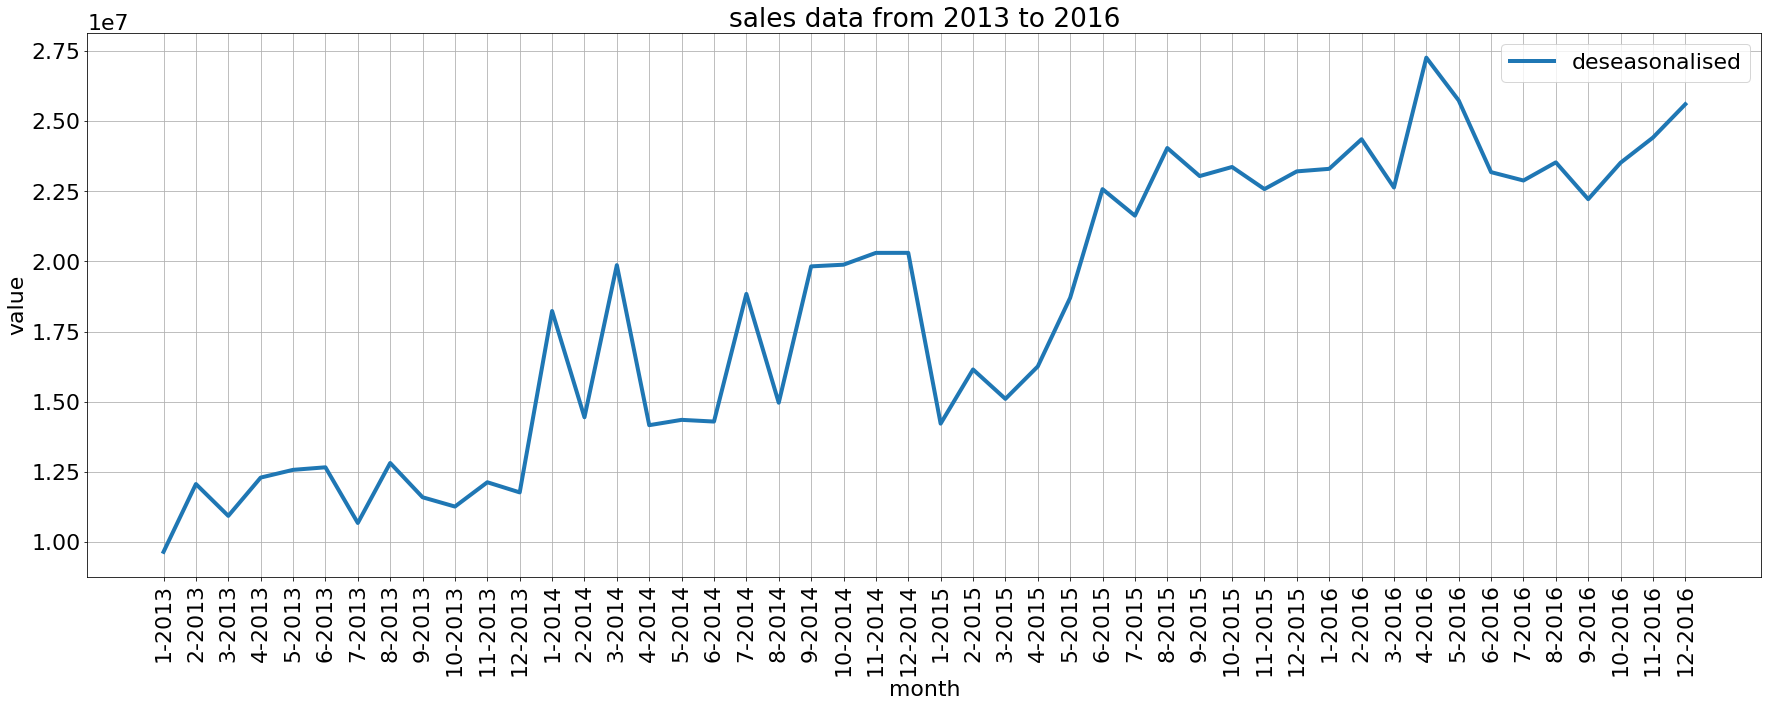

In [20]:
data['deseasonalised'] = data.timeseries - data.seasonal

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.deseasonalised, marker='', linestyle='-', label='deseasonalised', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Step 6: Find the Trend

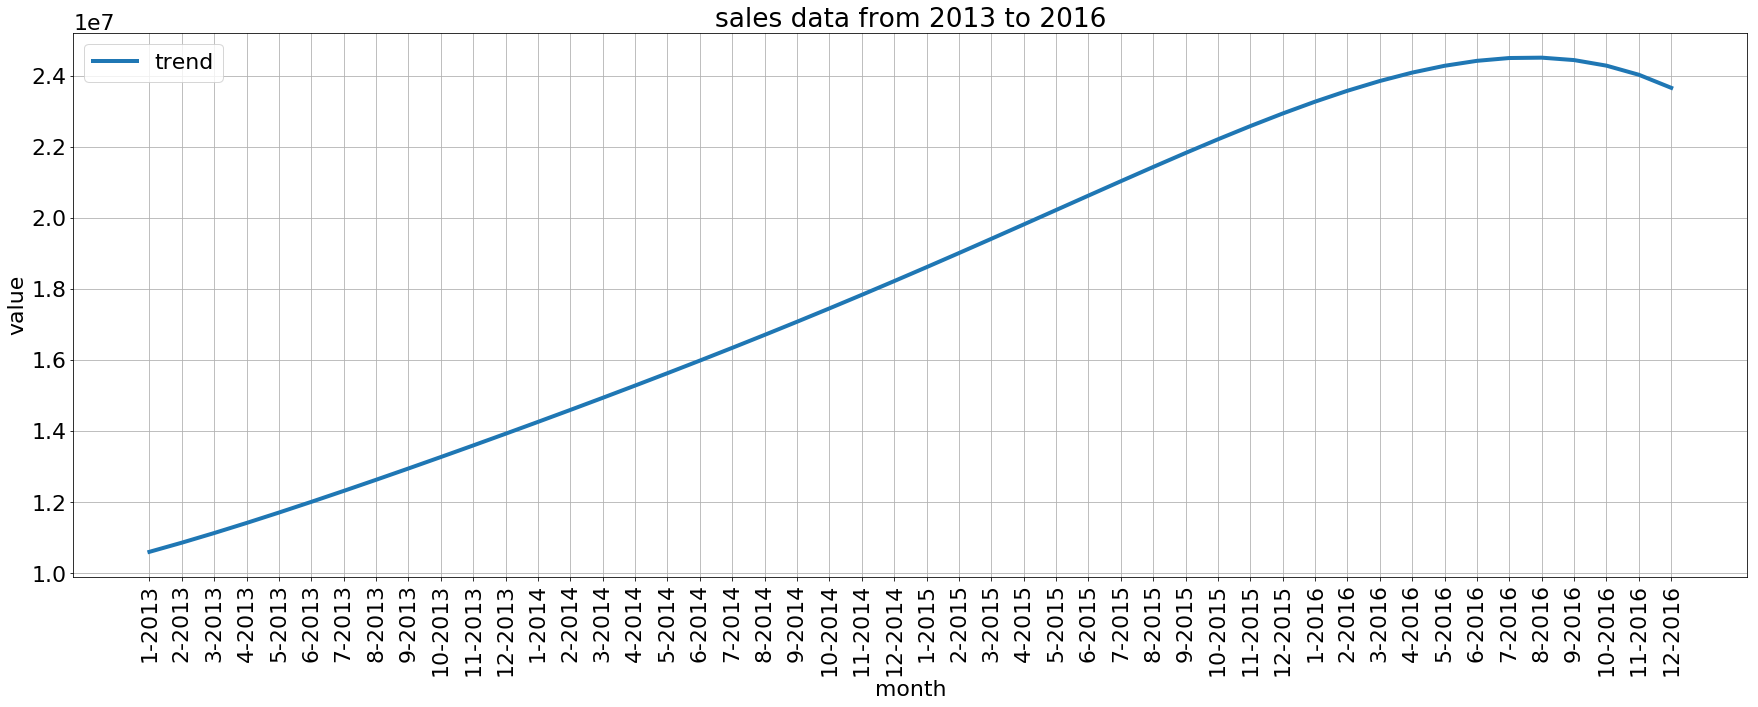

In [21]:
# fitting the polynomial model with deseasonalised data
scaler = MinMaxScaler()
scaler = scaler.fit(y.reshape(-1,1))
y_scaled = scaler.transform(data.deseasonalised.values.reshape(-1,1))

model = LinearRegression()
model = model.fit(X_poly, y_scaled)

# trend
trend = model.predict(X_poly)
data['trend'] = scaler.inverse_transform(trend)

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.trend, marker='', linestyle='-', label='trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Step 7: Find the Residual

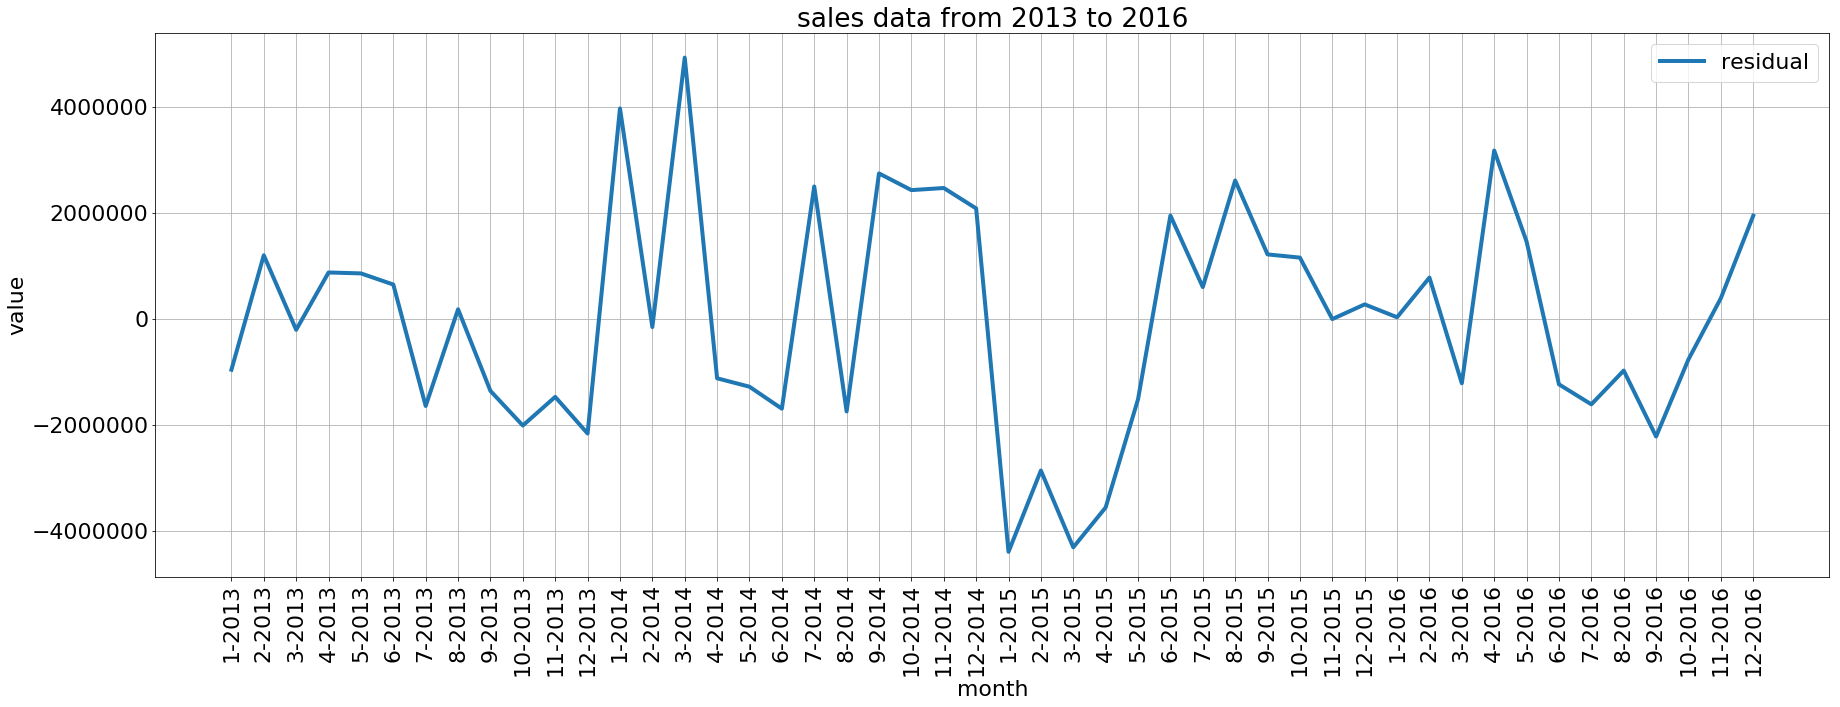

In [22]:
data['residual'] = data.timeseries - data.trend - data.seasonal

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.residual, marker='', linestyle='-', label='residual', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Final result

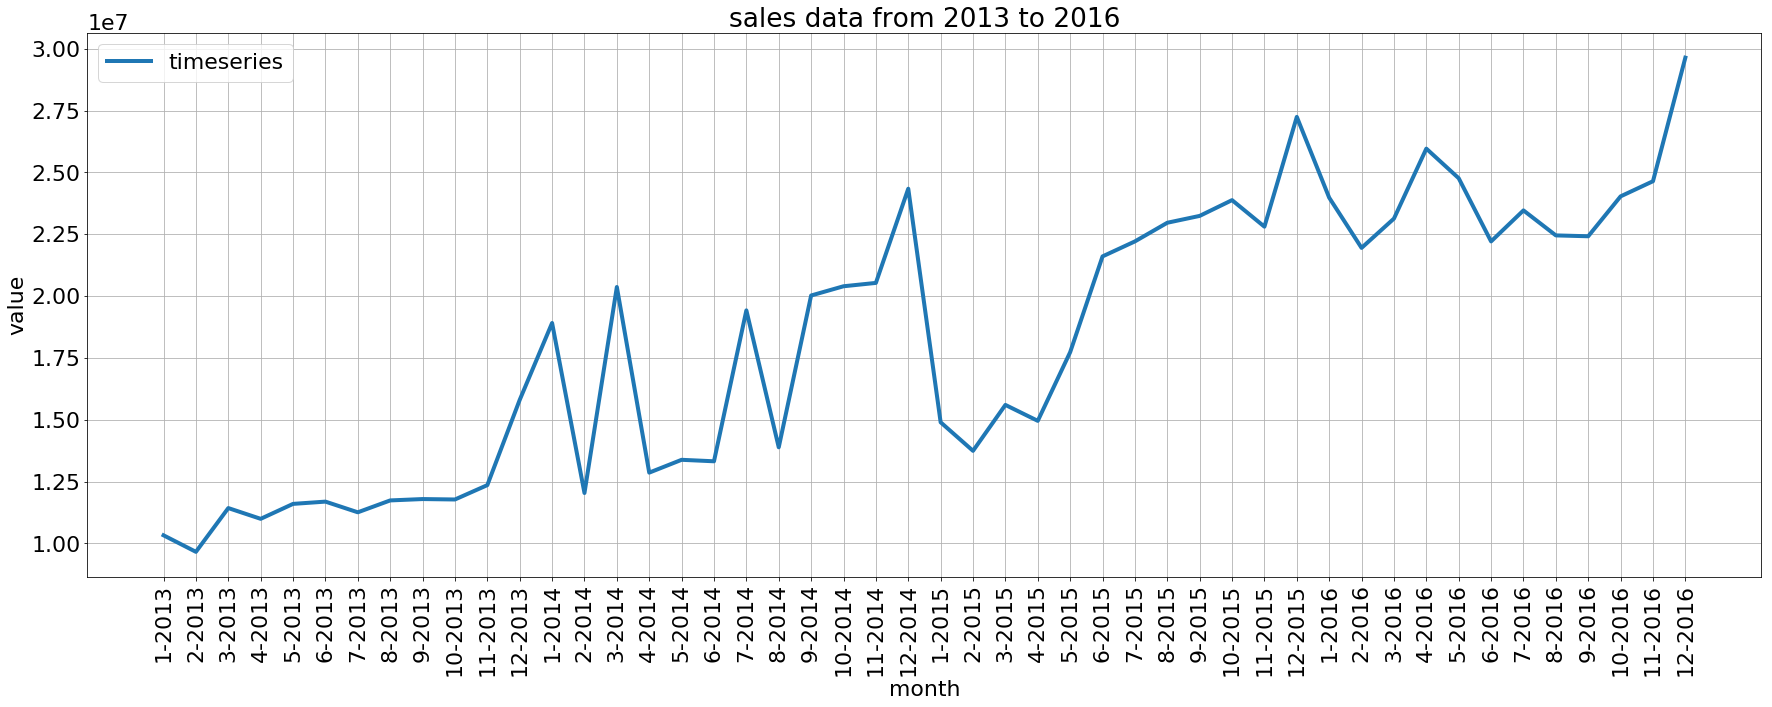

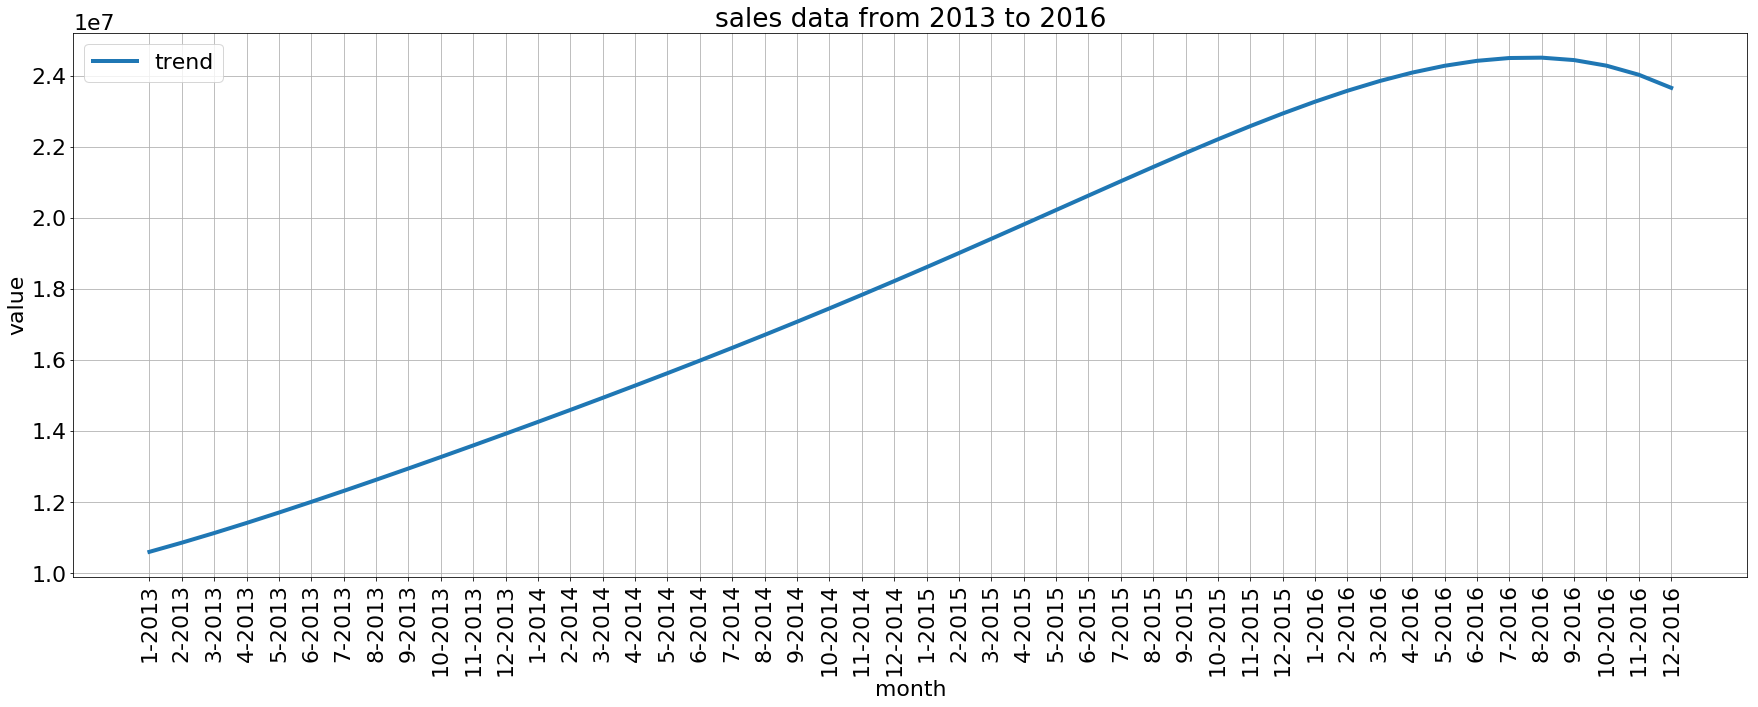

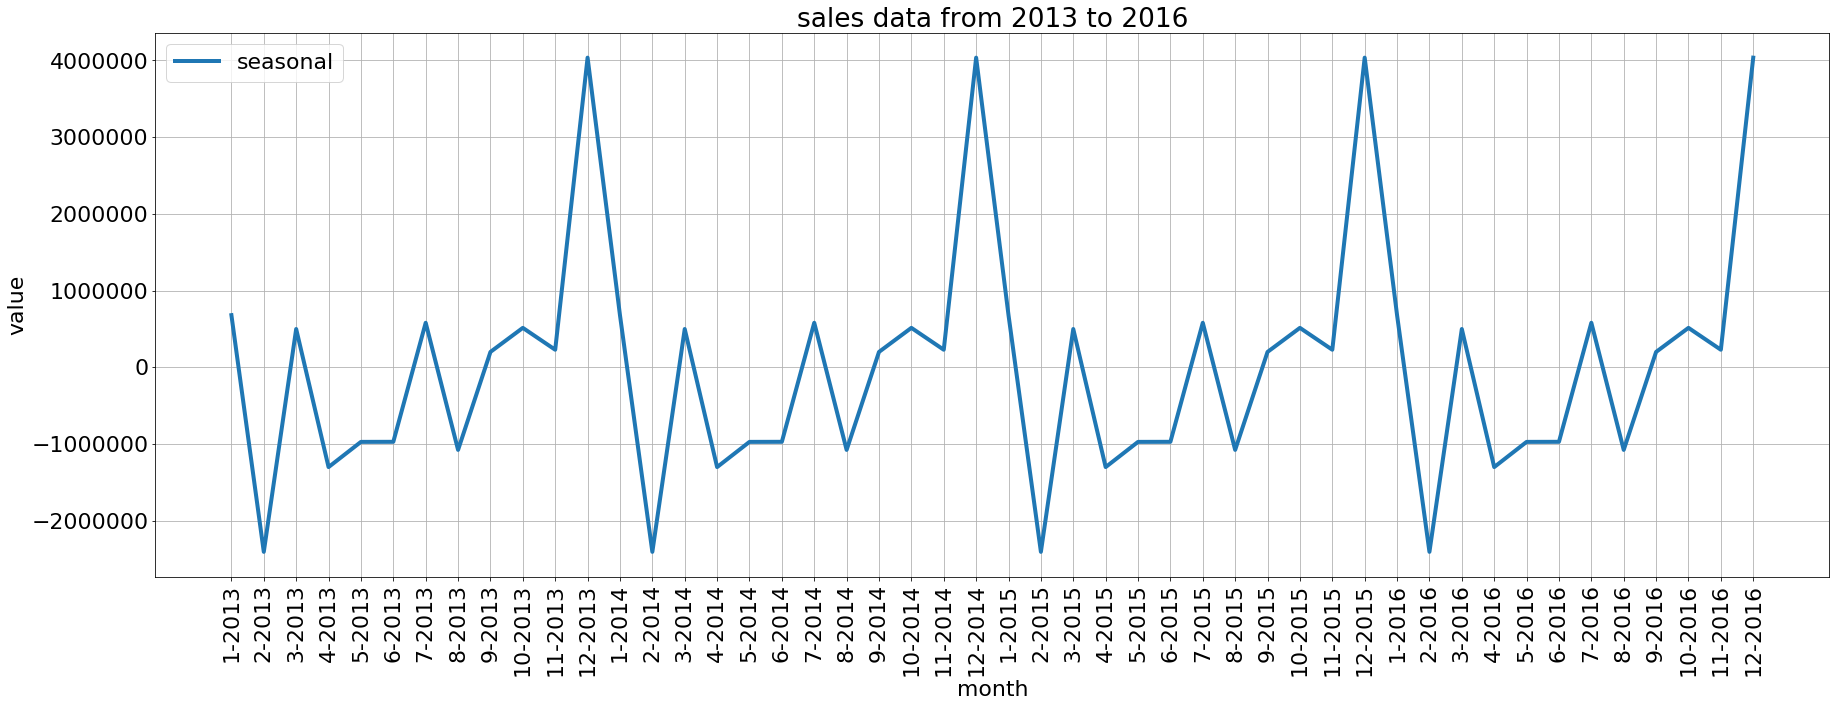

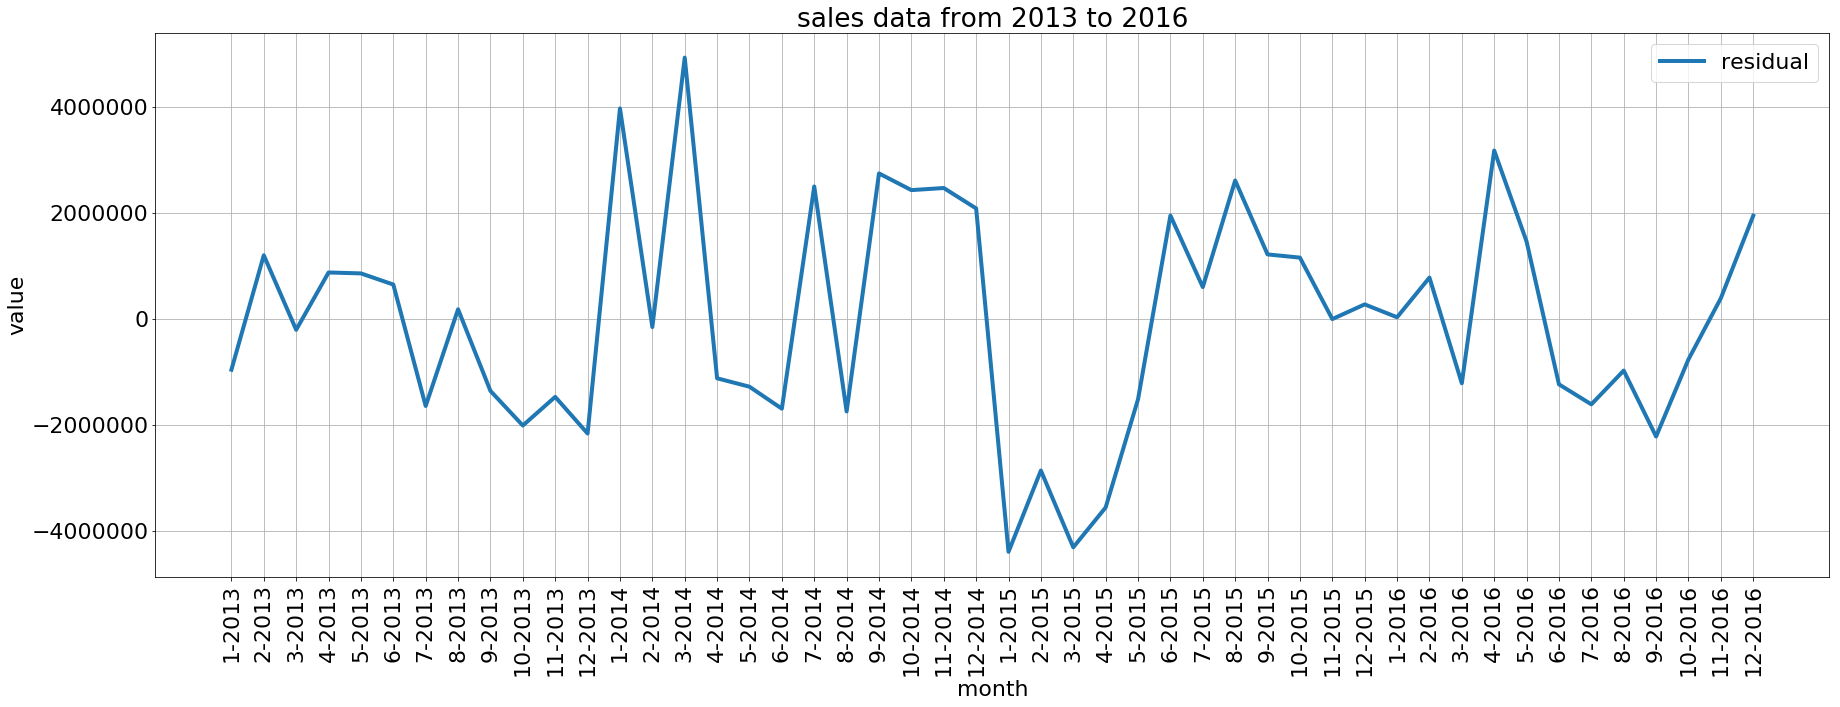

In [41]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.timeseries, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.trend, marker='', linestyle='-', label='trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.seasonal, marker='', linestyle='-', label='seasonal', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, data.residual, marker='', linestyle='-', label='residual', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# STL decomposition using statsmodel library

In [27]:
from stldecompose import decompose, forecast

temp = data.reset_index()
df_stl_month = temp[['index', 'timeseries']].set_index('index')
decomp = decompose(df_stl_month.values, period=12)

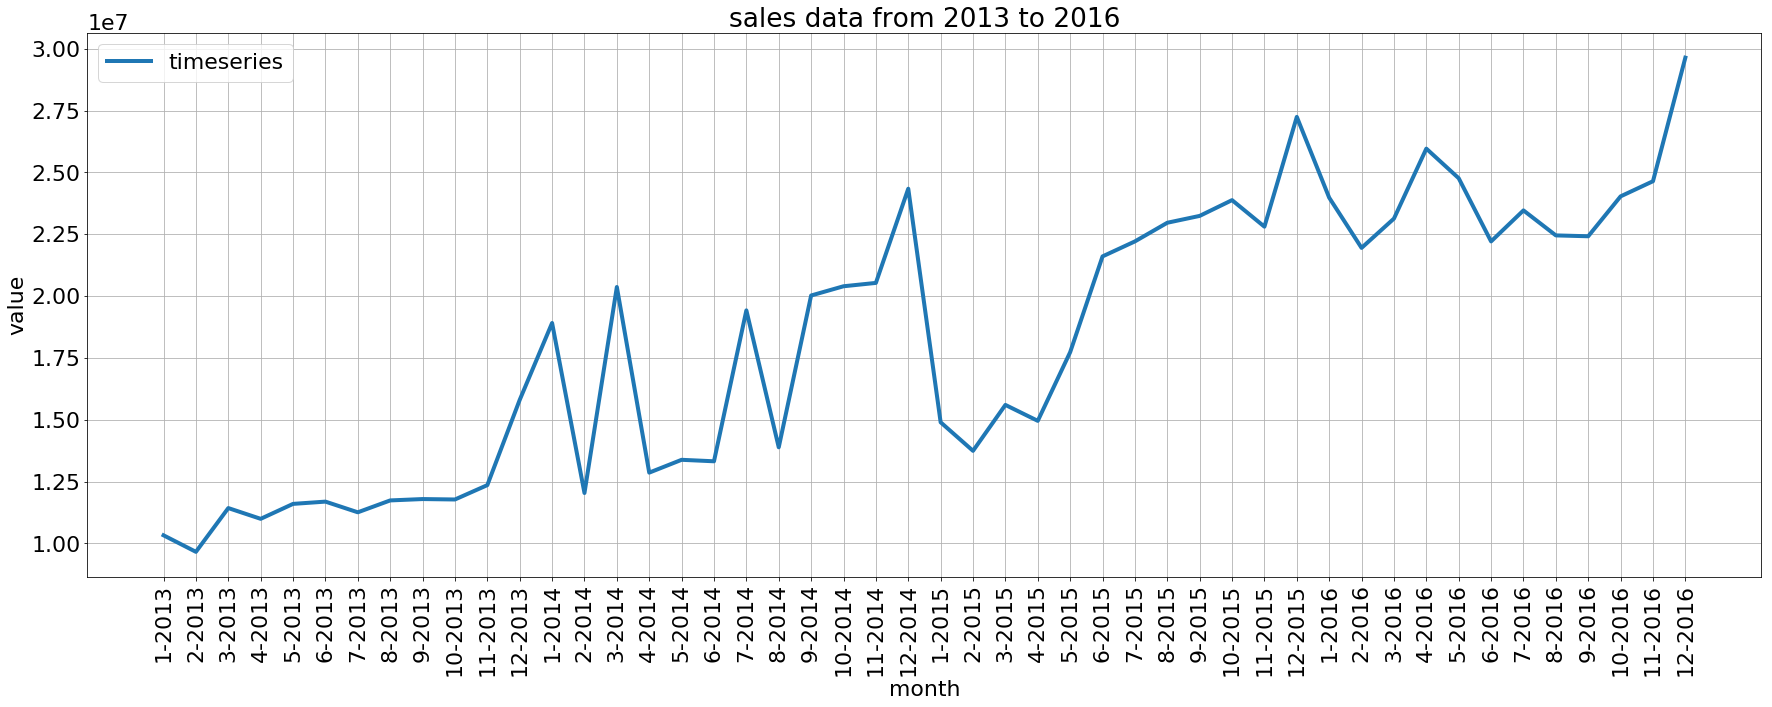

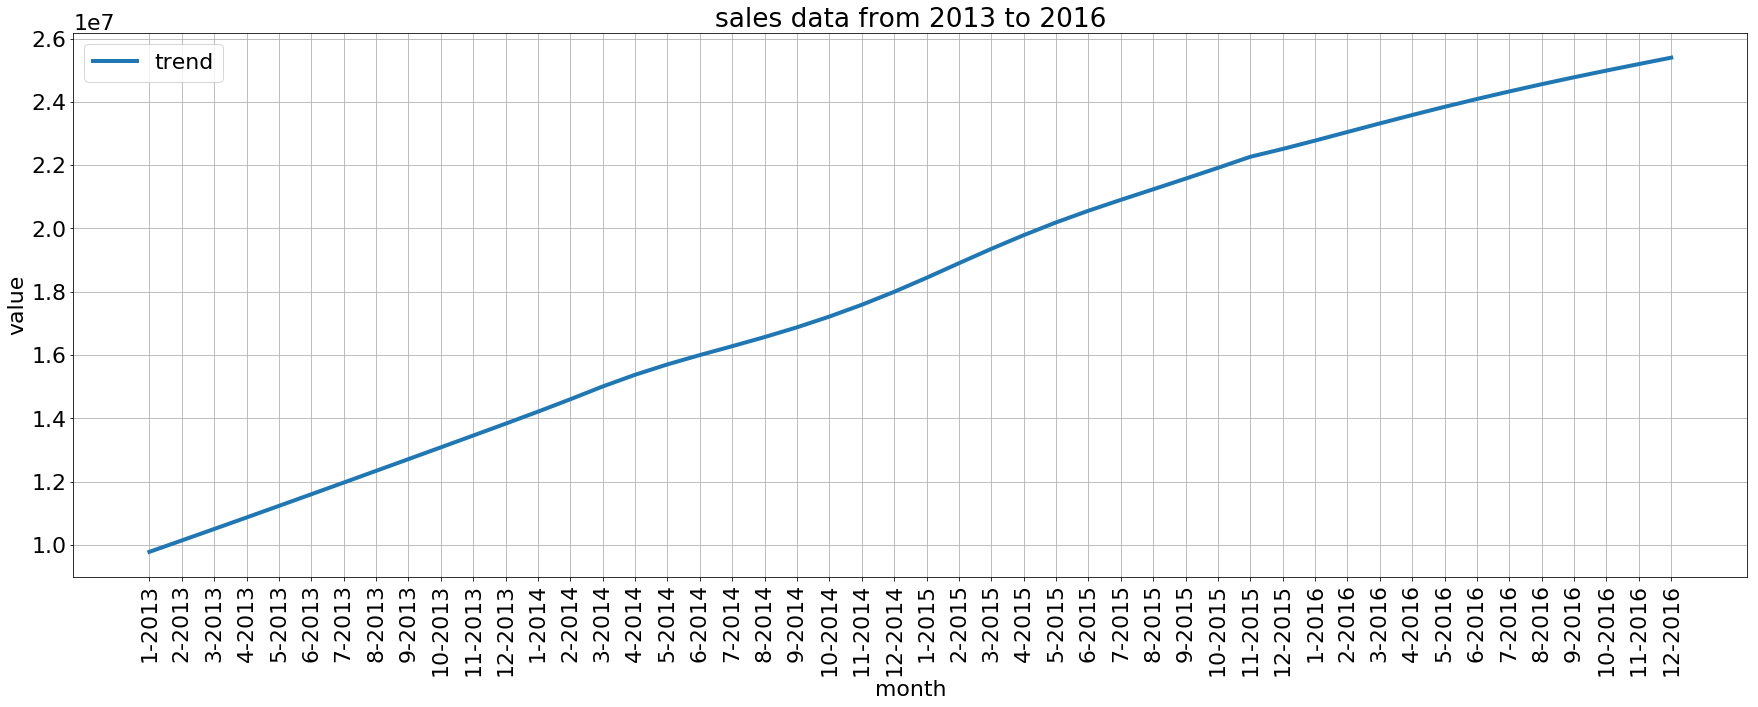

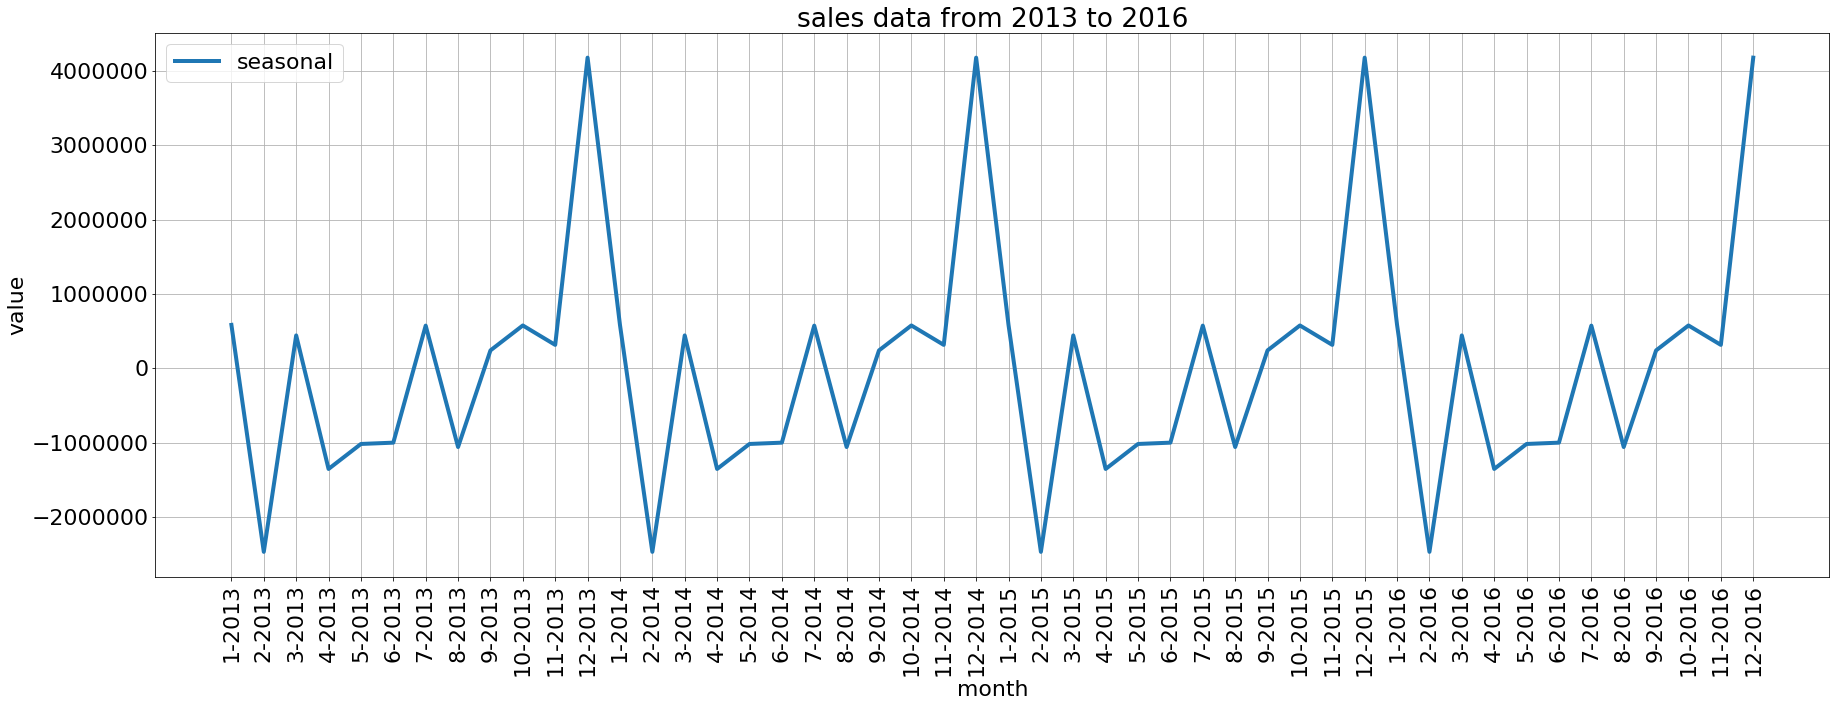

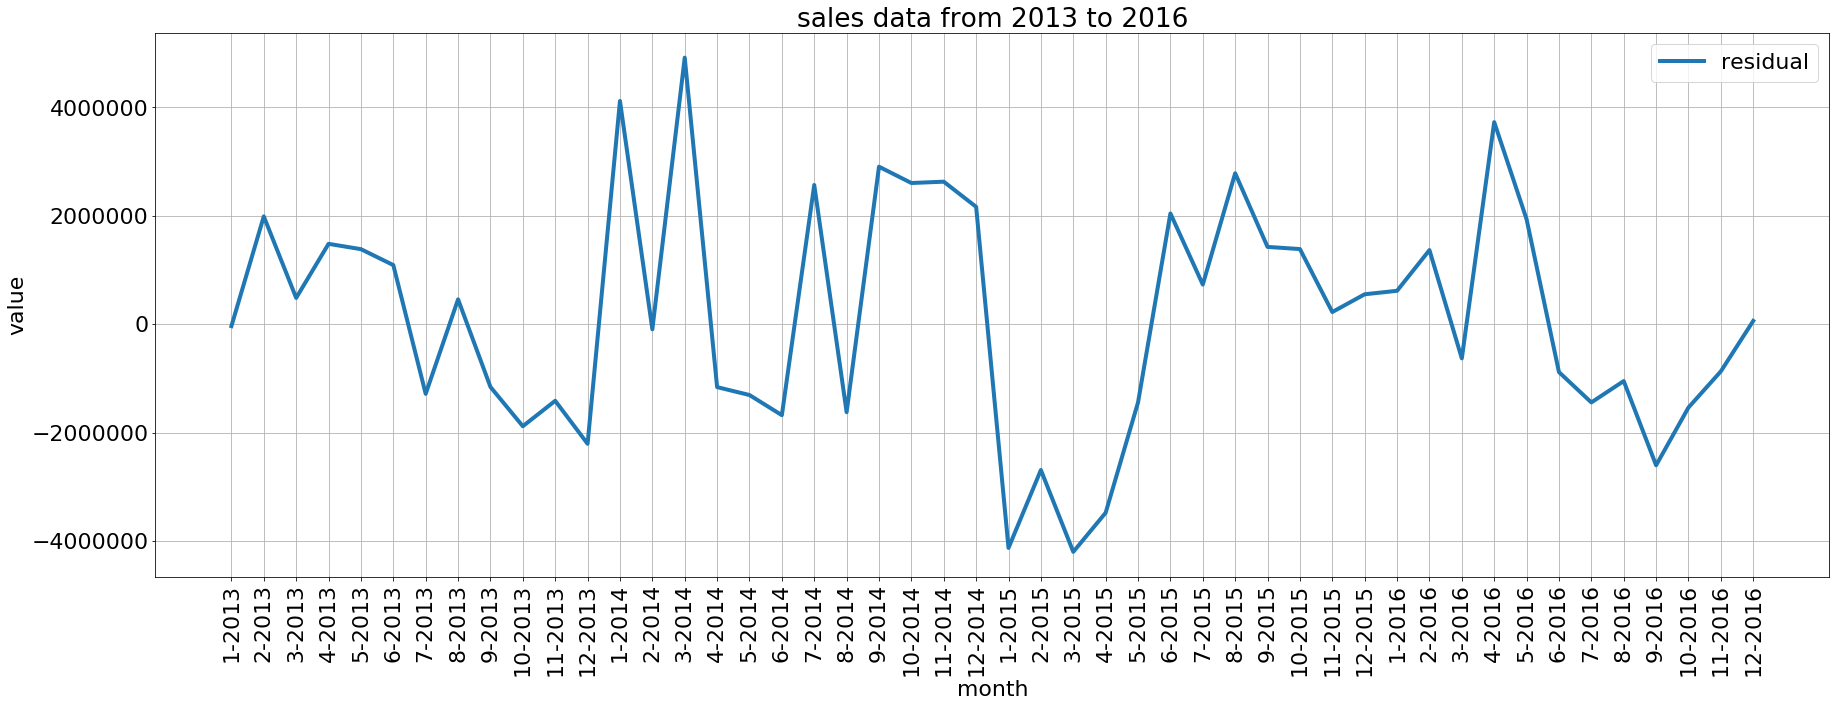

In [40]:
plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.observed, marker='', linestyle='-', label='timeseries', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.trend, marker='', linestyle='-', label='trend', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.seasonal, marker='', linestyle='-', label='seasonal', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 22})
plt.grid()
plt.plot(X_index, decomp.resid, marker='', linestyle='-', label='residual', linewidth=4)
plt.title("sales data from 2013 to 2016")
plt.xlabel("month")
plt.ylabel("value")
plt.xticks(rotation=90)
plt.legend()
plt.show()